<a href="https://colab.research.google.com/github/rohita77/Utils/blob/master/Google-vision-jpeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Imports and Installs

In [22]:
!pip install google.cloud.vision
!pip install google.cloud.storage

  Using cached https://files.pythonhosted.org/packages/f2/bf/112a0707a425961516693ac526725bc3f51db44fc3d02998da3ee2b82ef1/google_cloud_vision-0.36.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b6/e9/06d9bb394fddbc62bb9c645f5e1c927128930a249d0c6a7491c3f31a9ff4/google_cloud_storage-1.14.0-py2.py3-none-any.whl


In [0]:
!apt-get -qq install -y google.protobuf

In [0]:
!export GOOGLE_APPLICATION_CREDENTIALS='ml-poc-baaf9385cbe5.json'

In [0]:
 from google.cloud import vision
 from google.cloud import storage
 from google.protobuf import json_format
 import re
import numpy as np

In [0]:
import argparse
from enum import Enum
import io
import requests
from six.moves.urllib.request import urlopen
from six import BytesIO


In [0]:
from google.cloud.vision import types
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [0]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

## 2. Settings

In [0]:
key_path = 'ml-poc-baaf9385cbe5.json'

In [0]:
gcs_uri = 'https://storage.googleapis.com/'

In [0]:
client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

## 3. Definitions

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


In [0]:
def detect_document_uri(uri):
    """Detects document features in the file located in Google Cloud
    Storage."""
    image = vision.types.Image()
    image.source.image_uri = uri

    response = client.document_text_detection(image=image)
   
    for page in response.full_text_annotation.pages:
      
        for block in page.blocks:
            print('\nBlock confidence: {:.2f}\n'.format(block.confidence))

            for paragraph in block.paragraphs:
                print('Paragraph confidence: {:.2f}'.format(
                    paragraph.confidence))

                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])
                    print('Word text: {} ({:.1f})'.format(
                        word_text, word.confidence))

                    #for symbol in word.symbols:
                     #   print('\tSymbol: {} (confidence: {})'.format(
                      #      symbol.text, symbol.confidence))
            
        return response.full_text_annotation

In [0]:
def draw_boxes(image, bounds, color,offset=0,width=2):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

     
    for bound in bounds:
        draw.line([
            bound.vertices[0].x - offset, bound.vertices[0].y - offset,
            bound.vertices[1].x + offset, bound.vertices[1].y - offset,
            bound.vertices[2].x + offset, bound.vertices[2].y + offset,
            bound.vertices[3].x - offset, bound.vertices[3].y + offset], width=width,fill=color)
    return image

In [0]:
def get_document_bounds(document, feature):
    """Returns document bounds given an image."""

    bounds = []

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds

In [0]:
def render_doc_text(uri, fileout):
    #image = Image.open(filein)
    
    #image = vision.types.Image()
    #image.source.image_uri = filein
    
    #response = client.document_text_detection(image=image)

    ext = uri[-4:]
    
    if ext.find('.tif') > -1 :
      document = async_detect_document('gs://' + uri, fileout)
    else:
      document = detect_document_uri('gs://' + uri)
 

    response = urlopen(gcs_uri + uri)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  
  
    bounds = get_document_bounds(document, FeatureType.PAGE)
    #draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(document, FeatureType.PARA)
    draw_boxes(image, bounds, 'red',offset=1,width=3)
    bounds = get_document_bounds(document, FeatureType.WORD)
    draw_boxes(image, bounds, 'green',offset=0)

    #display_image(image)

#    if fileout is not 0:
#        image.save(fileout)
#
    # Here we print the full text from the first page.
    # The response contains more information:
    # annotation/pages/blocks/paragraphs/words/symbols
    # including confidence scores and bounding boxes
    print(u'Full text:\n{}'.format(
        document.text))
    
    return image

In [0]:
def async_detect_document(gcs_source_uri, gcs_destination_uri):
    """OCR with PDF/TIFF as source files on GCS"""
    # Supported mime_types are: 'application/pdf' and 'image/tiff'
    mime_type = 'image/tiff'

    # How many pages should be grouped into each json ou9tput file.
    batch_size = 2

    client = vision.ImageAnnotatorClient.from_service_account_json(key_path)

    feature = vision.types.Feature(
        type=vision.enums.Feature.Type.DOCUMENT_TEXT_DETECTION)

    gcs_source = vision.types.GcsSource(uri=gcs_source_uri)
    input_config = vision.types.InputConfig(
        gcs_source=gcs_source, mime_type=mime_type)

    gcs_destination = vision.types.GcsDestination(uri=gcs_destination_uri)
    output_config = vision.types.OutputConfig(
        gcs_destination=gcs_destination, batch_size=batch_size)

    async_request = vision.types.AsyncAnnotateFileRequest(
        features=[feature], input_config=input_config,
        output_config=output_config)

    operation = client.async_batch_annotate_files(
        requests=[async_request])

    print('Waiting for the operation to finish.')
    operation.result(timeout=180)

    # Once the request has completed and the output has been
    # written to GCS, we can list all the output files.
    storage_client = storage.Client.from_service_account_json(key_path)

    match = re.match(r'gs://([^/]+)/(.+)', gcs_destination_uri)
    bucket_name = match.group(1)
    prefix = match.group(2)

    bucket = storage_client.get_bucket(bucket_name=bucket_name)

    # List objects with the given prefix.
    blob_list = list(bucket.list_blobs(prefix=prefix))
    print('Output files:')
    for blob in blob_list:
        print(blob.name)

    # Process the first output file from GCS.
    # Since we specified batch_size=2, the first response contains
    # the first two pages of the input file.
    output = blob_list[0]

    json_string = output.download_as_string()
    response = json_format.Parse(
        json_string, vision.types.AnnotateFileResponse())

    # The actual response for the first page of the input file.
    first_page_response = response.responses[0]
    annotation = first_page_response.full_text_annotation

   
    return annotation

## 4. Examples




##### David Ben-7A -CenterBottom *PNG*





Block confidence: 0.74

Paragraph confidence: 0.74
Word text: DS01 (0.7)

Block confidence: 0.86

Paragraph confidence: 0.86
Word text: 7 (1.0)
Word text: . (1.0)
Word text: TELL (1.0)
Word text: US (1.0)
Word text: ABOUT (1.0)
Word text: YOURSELF (1.0)
Word text: Denotes (0.8)
Word text: mandatory (0.8)
Word text: nelas (0.6)

Block confidence: 0.97

Paragraph confidence: 0.97
Word text: Name (1.0)
Word text: as (1.0)
Word text: in (1.0)
Word text: NRIC (1.0)
Word text: / (1.0)
Word text: Passport (1.0)
Word text: * (1.0)
Word text: + (0.9)
Word text: ( (0.9)
Word text: underline (1.0)
Word text: surname (1.0)
Word text: ) (0.8)

Block confidence: 0.56

Paragraph confidence: 0.56
Word text: O (0.4)
Word text: M (0.7)

Block confidence: 0.66

Paragraph confidence: 0.66
Word text: O (0.6)
Word text: M (0.8)

Block confidence: 0.41

Paragraph confidence: 0.41
Word text: O (0.2)
Word text: Dr (0.5)

Block confidence: 0.99

Paragraph confidence: 0.99
Word text: Gender (1.0)

Block confide

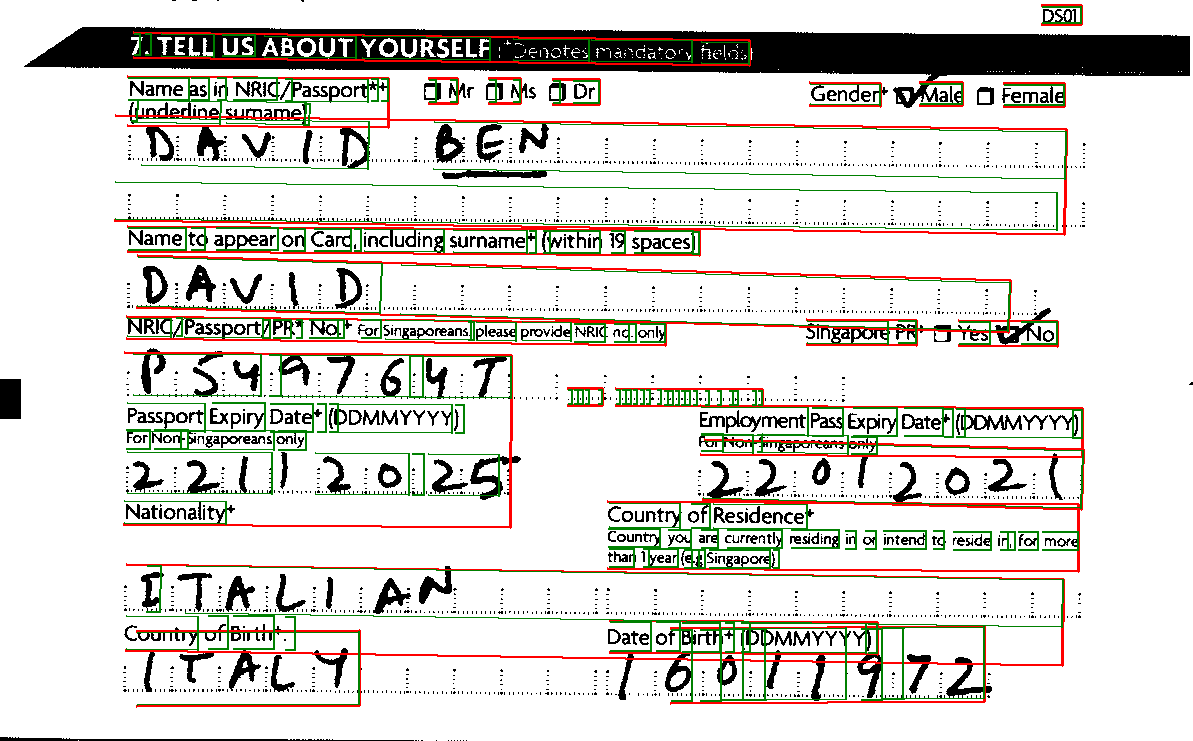

In [52]:
render_doc_text('ml-poc-213704-vcm/DavidBen-Section7-CenterBottom-TIF.png', 0)



##### David Ben-7A -TopRight *PNG*


Block confidence: 0.92

Paragraph confidence: 0.92
Word text: TELL (1.0)
Word text: US (1.0)
Word text: ABOUT (1.0)
Word text: YOURSELF (1.0)
Word text: * (0.9)
Word text: Denotes (0.9)
Word text: mandatory (0.9)
Word text: fields (0.8)
Word text: , (0.9)

Block confidence: 0.92

Paragraph confidence: 0.90
Word text: Marital (1.0)
Word text: Status (1.0)
Word text: Single (0.9)
Word text: Married (1.0)
Word text: Others (1.0)
Word text: : (1.0)
Word text: . (0.8)
Word text: Highest (1.0)
Word text: Educational (1.0)
Word text: Qualification (1.0)
Word text: Primary (0.8)
Word text: Secondary (0.9)
Word text: O (1.0)
Word text: ' (0.9)
Word text: N (0.9)
Word text: ' (0.9)
Word text: Level (0.9)
Word text: O (0.1)
Word text: ' (0.8)
Word text: level (0.7)
Word text: O (0.3)
Word text: ‘ (0.1)
Word text: A (0.8)
Word text: ’ (0.7)
Word text: Level (0.8)
Word text: Diploma (0.9)
Word text: I (0.3)
Word text: Degree (0.9)
Word text: Others (0.8)
Word text: ( (0.9)
Word text: please (1.0)


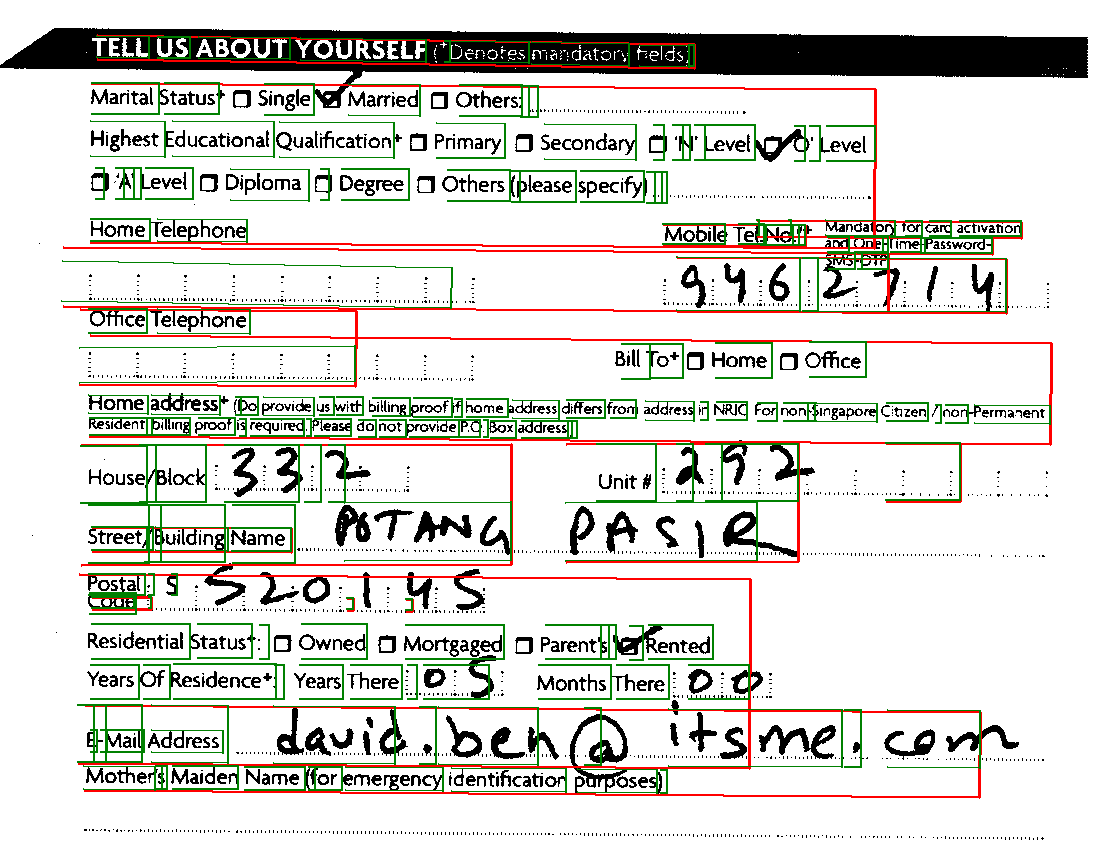

In [43]:
render_doc_text('ml-poc-213704-vcm/DavidBen-Section7-TopRight-TIF.png', 0)